In [23]:
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise
from scipy.ndimage import median_filter,gaussian_filter
from scipy import ndimage
import numpy  as np
from scipy.signal import convolve2d

In [24]:
img=cv2.imread("D:\imageprocessing\coins.tif",0)

# a) Thêm nhiễu Muối tiêu/Gaussian vào ảnh “coins.tif”

In [25]:
salt_pepper_noise = random_noise(img, mode='s&p', amount=0.02)  
gaussian_noise = random_noise(salt_pepper_noise, mode='gaussian', var=0.01) 

# b) Sử dụng bộ lọc Mean/ Gaussian để lọc nhiễu

In [26]:
img_filtered=median_filter(gaussian_filter(gaussian_noise,1),3)

# c) Dùng Canny (Dùng hàm tự viết ở bài 3) để phát hiện biên

In [27]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolve2d(img,Kx,mode="same")
    Iy = convolve2d(img,Ky,mode="same")
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [28]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [29]:

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09,Tlow= np.int32(25),Tup=np.int32(255)):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = Tlow
    strong = Tup
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


In [30]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [31]:
def Canny(img,thresholdLow,thresholdHigh):
    img=ndimage.gaussian_filter(img,1)
    G,theta=sobel_filters(img)
    img=non_max_suppression(G,theta)
    res,weak,strong=threshold(img,lowThresholdRatio=thresholdLow,highThresholdRatio=thresholdHigh)
    img_final=hysteresis(res,weak,thresholdHigh)
    return img_final

In [32]:
canny_filtered=Canny(img_filtered,0.05,0.09)
canny_noise=Canny(gaussian_noise,0.05,0.09)

 # d)Hiển thị và so sánh kết quả phát hiện biên trên ảnh nhiễu trước và sau khi lọc nhiễu

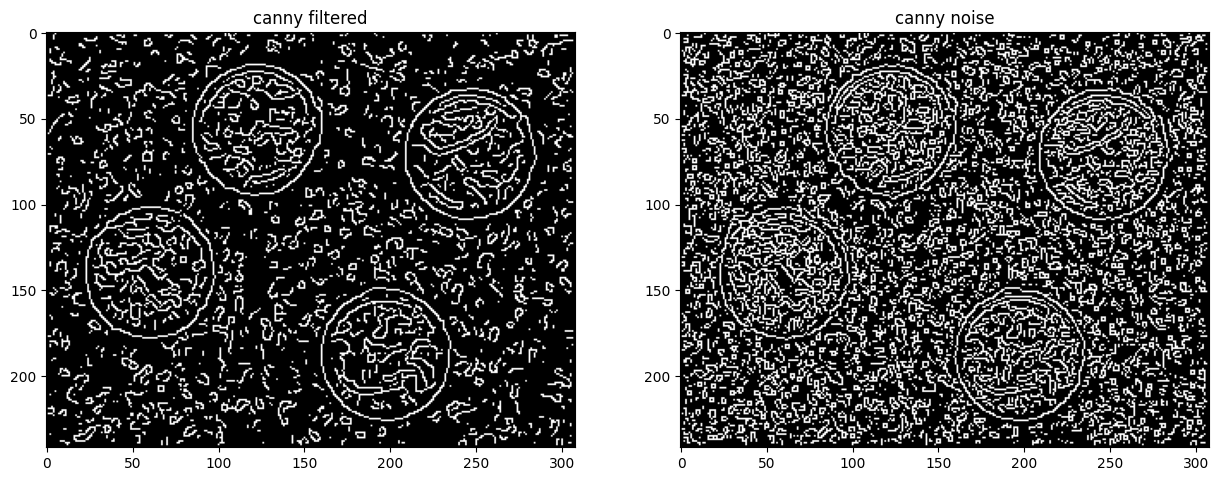

In [33]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title("canny filtered")
plt.imshow(canny_filtered,"gray")
plt.subplot(122)
plt.title("canny noise")
plt.imshow(canny_noise,"gray")

# sau khi lọc nhiễu thì cạnh được detect rõ ràng và sắc nét hơn